# SpaCy matching

## import packages

In [2]:
#import packages
import sqlite3
import pandas as pd
from utils import preprocess_data, get_matches

In [10]:
# sqlite_con = sqlite3.connect(".local/fake_clin_data.db")
# free_text_data = pd.read_sql_query(
#     "SELECT distinct Bezeichnung FROM Substanz", sqlite_con
# )
# sqlite_con.close()

free_text_data = pd.read_csv("../data/Test_Daten.csv", sep = ";", encoding="utf-8")

col_with_substances_ZfKD_fake_data = free_text_data["Bezeichnung"]


# get valid substance from reference list provided by ZfKD 
URL_LINK = "https://gitlab.opencode.de/robert-koch-institut/zentrum-fuer-krebsregisterdaten/cancerdata-references/-/raw/main/data/v2/Klassifikationen/substanz.csv?ref_type=heads"
reference_list = pd.read_csv(URL_LINK, sep=";")
col_with_ref_substances_ZfKD = reference_list["substanz"]

## Create functions

In [11]:
# define function to extract valid substances
def create_substance_service_var(
    col_with_substances: pd.Series,
    col_with_ref_substances: pd.Series,
    threshold: float = 0.85,
    max_per_match_id: int = 2,
    only_first_match: bool = False,
) -> pd.DataFrame:
    """
    This is the pipeline for creating the service variable
    for substances using ZfKD data.
    The functions are described in detail in utils.py.
    In short, the functions takes a pandasDataFrame column
    as an input and preprocesses its entries first.
    This results in a pandasDataFrame with the original
    input in one column and the preprocessed text in another one.
    The fuzzy matching relies on FuzzyMatcher from spaczz.
    It uses the preprocessed input and a reference list that
    the uses needs to provide. The reference list must be 
    a pandasDataFrame column (pd.Series) with substance names.
    The output is a pandasDataFrame with the original input,
    the preprocessed text and all possible matches with similary score.
    Use parameters to control output and sensitivity of the matcher. 
    """
    preprocessed_out = preprocess_data(col_with_substances)

    final_output = get_matches(
        preprocessed_out,
        col_with_ref_substances,
        threshold=threshold,
        max_per_match_id=max_per_match_id,
        only_first_match=only_first_match,
    )

    return final_output

## Examine the impact of threshold parameter 

In [12]:
# containers
threshold_value = []
similarity_mean = []
match_count = []

threshold_range = range(60, 100)

for threshold in threshold_range:
    results_atomic = create_substance_service_var(
        col_with_substances=col_with_substances_ZfKD_fake_data,
        col_with_ref_substances=col_with_ref_substances_ZfKD,
        only_first_match=True,
        max_per_match_id=1,
        threshold=threshold/100  
    )

    valid_hits = results_atomic["Hit"].dropna()
    valid_hits = valid_hits[valid_hits != ""]
    count = len(valid_hits)

    mean_sim = pd.to_numeric(results_atomic["Similarity"], errors='coerce').mean()

    threshold_value.append(threshold)
    match_count.append(count)
    similarity_mean.append(mean_sim)


results_df = pd.DataFrame({
    "threshold": threshold_value,
    "match_count": match_count,
    "similarity_mean": similarity_mean
})

print(results_df)    

    threshold  match_count  similarity_mean
0          60         2538        96.978329
1          61         2538        96.978329
2          62         2538        96.978329
3          63         2538        96.978329
4          64         2538        96.978329
5          65         2538        96.978329
6          66         2538        96.978329
7          67         2538        96.978329
8          68         2538        96.978329
9          69         2538        96.978329
10         70         2538        96.978329
11         71         2538        96.978329
12         72         2538        96.978329
13         73         2538        96.978329
14         74         2538        96.978329
15         75         2538        96.978329
16         76         2511        97.214656
17         77         2471        97.558074
18         78         2454        97.700489
19         79         2417        98.002069
20         80         2410        98.057261
21         81         2378      

In [13]:
results_df['match_count_relative'] = results_df['match_count'] / len(col_with_substances_ZfKD_fake_data)

## Plot match count based on threshold value

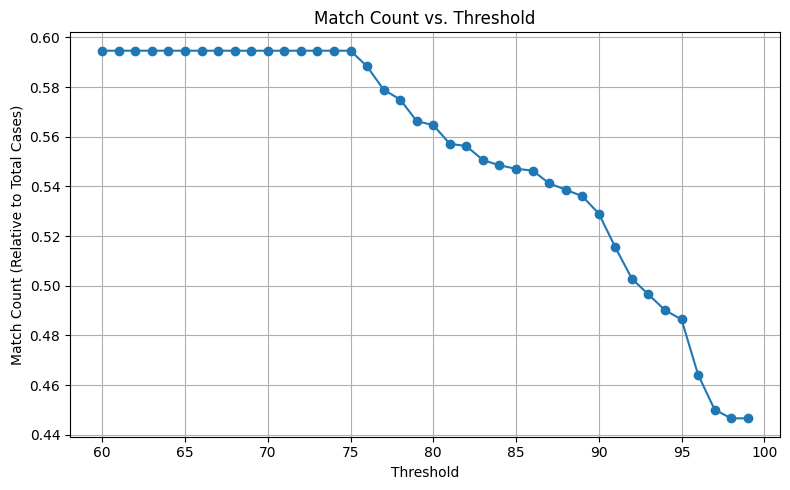

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df['threshold'], results_df['match_count_relative'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Match Count (Relative to Total Cases)')
plt.title('Match Count vs. Threshold')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/plot_match_count_vs_threshold.png', dpi=300)
plt.show()

In [17]:
col_with_made_up_data = pd.Series(["Interferon alpha 2a", "Paclitaxel (nab)", "Filgrastim", "Leuprorelin; Tamoxifen"])

results_atomic = create_substance_service_var(
    col_with_substances=col_with_made_up_data,
    col_with_ref_substances=col_with_ref_substances_ZfKD,
    only_first_match=True
)

results_multiple_hits = create_substance_service_var(
    col_with_substances=col_with_made_up_data,
    col_with_ref_substances=col_with_ref_substances_ZfKD,
    only_first_match=False,
    threshold=0.85,
    max_per_match_id=2
)

In [18]:
results_atomic.head()

,Original,Preprocessed,Hit,Mapped_to,Similarity
0,Interferon alpha 2a,Interferon alpha,Interferon alpha,Interferon alpha-2b,91
1,Paclitaxel (nab),Paclitaxel (nab),Paclitaxel,Paclitaxel,100
2,Filgrastim,Filgrastim,Filgrastim,Filgrastim,100
3,Leuprorelin; Tamoxifen,Leuprorelin; Tamoxifen,Leuprorelin,Leuprorelin,100


In [19]:
results_multiple_hits.head()

,Original,Preprocessed,Hit1,Mapped_to1,Similarity1,Hit2,Mapped_to2,Similarity2
0,Interferon alpha 2a,Interferon alpha,Interferon alpha,Interferon alpha-2b,91,Interferon alpha,Interferon alpha-2a,91
1,Paclitaxel (nab),Paclitaxel (nab),Paclitaxel,Paclitaxel,100,Paclitaxel (nab,Paclitaxel nab,97
2,Filgrastim,Filgrastim,Filgrastim,Filgrastim,100,Filgrastim,Pegfilgrastim,87
3,Leuprorelin; Tamoxifen,Leuprorelin; Tamoxifen,Leuprorelin,Leuprorelin,100,Tamoxifen,Tamoxifen,100


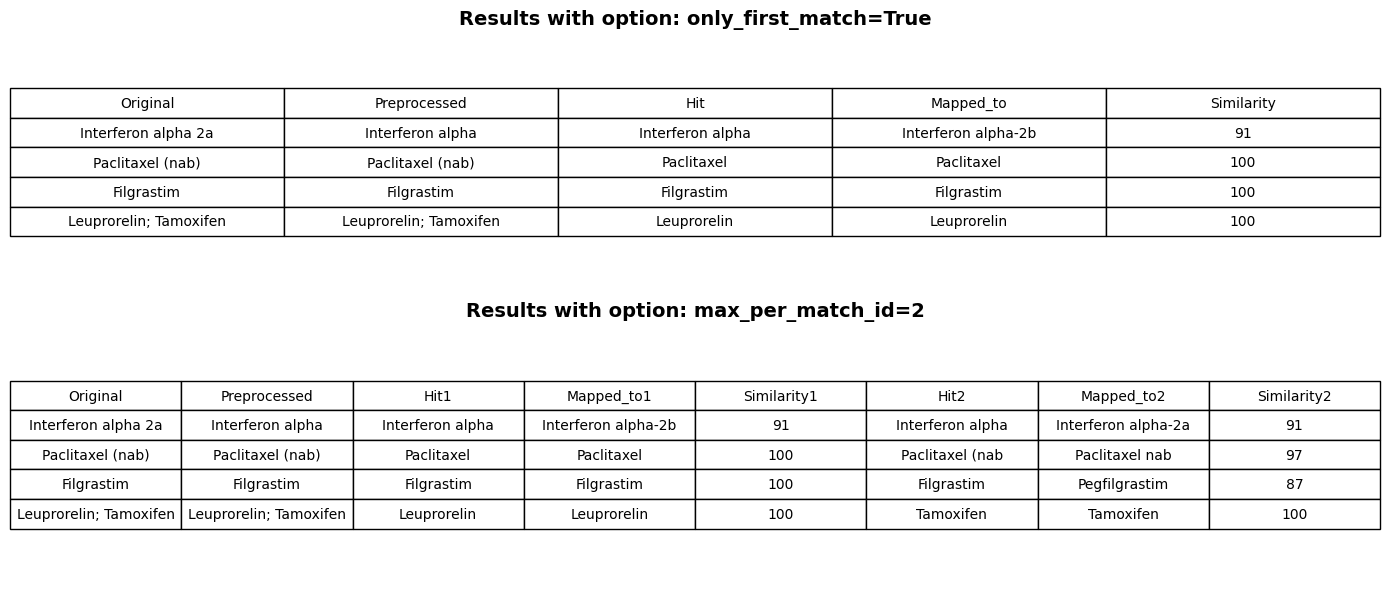

In [20]:
table_data1 = results_atomic.head()
table_data2 = results_multiple_hits.head()

# Set up vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))  # Adjust height as needed

# Plot first table
ax1.axis('off')
ax1.set_title('Results with option: only_first_match=True', fontsize=14, fontweight='bold', pad=10)
table1 = ax1.table(cellText=table_data1.values,
                   colLabels=table_data1.columns,
                   cellLoc='center',
                   loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 1.5)

# Plot second table
ax2.axis('off')
ax2.set_title('Results with option: max_per_match_id=2', fontsize=14, fontweight='bold', pad=10)
table2 = ax2.table(cellText=table_data2.values,
                   colLabels=table_data2.columns,
                   cellLoc='center',
                   loc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 1.5)

# Save the figure
plt.tight_layout()
plt.savefig('../images/atomic_vs_multiple.png', dpi=300, bbox_inches='tight')
plt.show()